# Plot all radar calibration patterns using halo-flight-phase-separation

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import yaml
import urllib.request
import xarray as xr
from intake import open_catalog

# this creates a nice progess bar but is not important for the function
try:
    from tqdm.notebook import tqdm
except:
    tqdm = lambda x: x

In [3]:
def fix_bahamas_ql(ds):
    ds = ds.rename({"tid": "time"})
    return xr.Dataset({
        "time": ds.TIME,
        "lat": ds.IRS_LAT,
        "lon": ds.IRS_LON,
    }).load()

## Get all flight segments from github and BAHAMAS data from AERIS via intake

In [4]:
segments = yaml.load(urllib.request.urlopen("https://github.com/eurec4a/flight-phase-separation/releases/download/v1.0.1-rc1/all_flights.yaml"), Loader=yaml.SafeLoader)
catalog = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")

## Loop over all flights and extract radar calibration flight segments

In [5]:
nav_ct = []
nav_cw = []
nav_al = []

for flight_id, flight in tqdm(segments["HALO"].items()):
    seg_ct = [s for s in flight["segments"] if s["kinds"] == ["radar_calibration_tilted"]]
    seg_cw = [s for s in flight["segments"] if s["kinds"] == ["radar_calibration_wiggle"]]

    ds = fix_bahamas_ql(catalog.halo.bahamas.ql.by_flight_id[flight_id].to_dask())
    
    for ct in seg_ct:
        nav_ct.append(ds.sel(time=slice(ct["start"], ct["end"])))

    for cw in seg_cw:
        nav_cw.append(ds.sel(time=slice(cw["start"], cw["end"])))
            
    nav_al.append(ds)

## Plot all flights and mark radar calibration flight segments

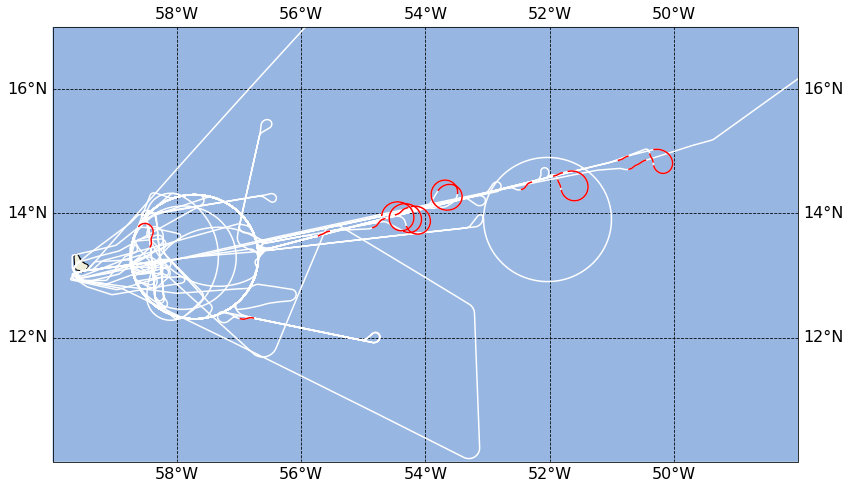

In [6]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = figure(figsize=(15,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='black', linewidth=1)

for al in nav_al:
    plt.plot(al.lon[::10], al.lat[::10], color='white')
    
for ct in nav_ct:
    plt.plot(ct.lon, ct.lat, color='red')

for cw in nav_cw:
    plt.plot(cw.lon, cw.lat, color='red')
    
ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')

plt.xlim(-60, -48.)
plt.ylim(10, 17)

xticks=[-60, -58, -56, -54, -52, -50, -48]
yticks=[10, 12, 14, 16, 18]
gl = ax.gridlines(draw_labels=True, xlocs=xticks, ylocs=yticks, color='black', linestyle='--')

gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}